# Talktorial 6

# Maximum common substructure

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Oliver Nagel

## Aim of this talktorial

Clustering and classification of large scale chemical data is essential for navigation, analysis and knowledge discovery in a wide variety of chemical application domains in drug discovery.

We learned in the last talktorial how to **group molecules (clustering)** and found that the **molecules in one cluster look similar to each other** and **share a common scaffold**. Besides visual inspection, we will learn here how to calculate the maximum substructure that a set of molecules has in common. 

## Learning goals

* What is a maximum common substructure (MCS)?
* How to calculate the MCS of a group of molecules?

### Theory

* Introduction to identification of maximum common substructure in a set of molecules
* Detailed explanation of the FMCS algorithm

### Practical

* Application of FMCS algorithm to a set of molecules (Cluster data taken from **talktorial 5** or EGFR molecules from **talktorial 1**)
* Identification of MCS using interactive cut-off adaption

## References

* Dalke A, Hastings J., FMCS: a novel algorithm for the multiple MCS problem. [*J. Cheminf.* 2013; 5(Suppl 1): O6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3606201/)
* Raymond JW., Willet P., Maximum common subgraph isomorphism algorithms for the matching of chemical structures. [*J Comput Aided Mol Des.* 2002 Jul;16(7):521-33](https://link.springer.com/article/10.1023/A:1021271615909)
* Dalke's website with info on algorithm: http://dalkescientific.com/writings/diary/archive/2012/05/12/mcs_background.html
* rdkit Cookbook documentation on MCS: http://www.rdkit.org/docs/Cookbook.html#using-custom-mcs-atom-types 

_____________________________________________________________________________________________________________________


## Theory

### Introduction

<img src="./images/mymols.png" width="300" align='right'>

The **maximum common structure (MCS)** is defined as the **largest substructure** that appears in two or more candidate molecules
* Finding the MCS = maximum common subgraph isomorphism problem
* Has **many applications** in the field of cheminformatics: similarity search, hierarchical clustering, or molecule alignment.
* Advantages:
 * Intuitive $\rightarrow$ shared structure among candidates likely to be important
 * Provides insight into possible activity patterns
 * Easy visualization by simply highlighting the substructure

Details on MCS algorithms (see review: [*J Comput Aided Mol Des.* 2002 Jul;16(7):521-33](https://link.springer.com/article/10.1023/A:1021271615909))
* Determining an MCS between two or more graphs is an NP-complete problem
* Algorithms for exact determination as well as approximations exist
    * Exact: Maximum-clique, backtracking, dynamic programming
    * Approximate: Genetic algorithm, combinatorial optimization, fragment storage, ... 
    * Problem reduction: simplify the molecular graphs


[FMCS](http://dalkescientific.com/writings/diary/archive/2012/05/12/mcs_background.html) algorithm:
* Models MCS problem as a graph isomorphism problem
* Based on subgraph enumeration and subgraph isomorphism testing

### Detailed explanation of FMCS algorithm
As explained in [*J. Cheminf.* 2013; 5(Suppl 1): O6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3606201/) and the respective [rdkit fmcs documentaion](https://www.rdkit.org/docs/source/rdkit.Chem.fmcs.fmcs.html).

#### The simplified algorithm description:

```
best_substructure = None
pick one structure in the set as query, all other as targets
for each substructure in the query:
    convert into a SMARTS string based on the desired match properties
    if SMARTS pattern exists in all of the targets:
        then it is a common substructure
        keep track of the maximum of such substructure
```

This simple approach alone will usually take a long time, but there are certain tricks used to speed up the run time.

#### Bond elimination
<img src="./images/transition.png" width="350" align='right'>

* Remove bonds that cannot be part of the MCS
* Atom and bond type information has to be present in every input structure
* Bond type: string consisting of SMARTS of the first atom, the bond and the second atom
* Exclude all bond types not present in all input structures, delete respective edges
* Result: fragmented structures with all atom information, but fewer edges (bonds)


#### Use the structure with the smallest largest fragment as the query

<img src="./images/query.png" width="150" align='right'>

* Heuristic approach:
    * Find largest fragment of each input structure
    * Sort input structures ascending by number of bonds in largest fragment
    * Solve ties with number of atoms, input order as alternative

* Structure with smallest largest fragment is the query structure
* The ones from the other input structures are the targets



#### Use a breadth-first search (BFS) and a priority queue to enumerate the fragment subgraphs

__A)__
* Enumeration based on growing a so called seed
* Seed: atoms/bonds in current subgraph, exclusion set (bonds not applicable for growth)
<img src="./images/seeds.png" width="150" align='right'>
* To prevent redundancy:
    * Initial seed is first bond in the fragment, can potentially grow to size of whole fragment
    * Second seed is second bond, is excluded from using the firs bond
    * Third seed starts from the third bond, excluded from using the first and second
    * ...
    
__B)__
* Seed grows along connected bonds (not in exclusions set or already in seed)
<img src="./images/growing.png" width="350" align='right'>
* All growth possibilities are considered at every step
* E.g. if there are N possible bonds for extension, $2^{N-1}$ possible new seeds are added to queue
* Enumeration ends when there are no new bonds to add to subgraph (exclude seed from queue)
* Largest seed will be processed first

#### Prune seeds not present in all of the other structures

* At each growth state $\rightarrow$ check if new seed exists in all other structures
* Else: exclude seed from queue

#### Prune seeds without sufficient growing potential
* Evaluation of growth potential from exclusion list and possible edges for extension
* If potential smaller than current best subgraph -> exclude seed from queue

Utilizing these approaches it is trivial to then keep track of the largest subgraph which corresponds to the maximum common substructure.

## Practical

In [1]:
import matplotlib.pyplot as plt
from rdkit import Chem
from collections import defaultdict
from rdkit.Chem import AllChem, Draw, rdFMCS, PandasTools
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import numpy, random
from ipywidgets import interact, fixed, widgets
IPythonConsole.ipython_useSVG=True

### Load and draw molecules

Set with 143 molecules loaded


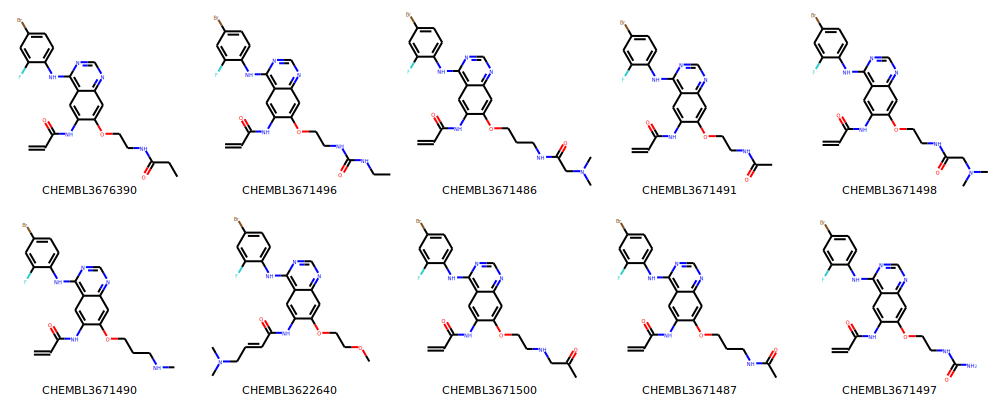

In [2]:
suppl = Chem.SDMolSupplier('../data/T5/molSet_largestCluster.sdf')
mols = [x for x in suppl]
print('Set with %d molecules loaded'%(len(mols)))

# Show only first 10 molecules
Draw.MolsToGridImage(mols[:10], legends=[mol.GetProp("_Name") for mol in mols[:10]], molsPerRow=5)

### Run the FMCS algorithm implemented in RDKit with different input parameters

#### Default values

In the simplest case only a list of molecules is given as a parameter.

In [3]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)

MCS1 contains 24 atoms and 26 bonds.
MCS SMARTS string: [#6]-[#6]-[#8]-[#6]1:[#6]:[#6]2:[#7]:[#6]:[#7]:[#6](:[#6]:2:[#6]:[#6]:1-[#7]-[#6](=[#8])-[#6])-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


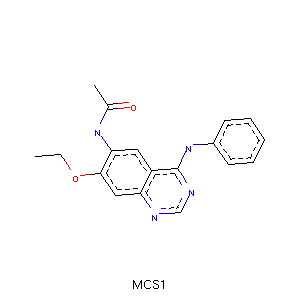

In [4]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

Define a helper function to draw the molecules with the highlighted MCS.

In [5]:
# Highlight the MCS in our query molecules
def highlightMolecules(cur_mols, cur_mcs, num, label=True):
    pattern = Chem.MolFromSmarts(cur_mcs.smartsString)
    matching = [cur_mols[i].GetSubstructMatch(pattern) for i in range(0,len(cur_mols))]
    
    if label==True:
        return Draw.MolsToGridImage(cur_mols[:num], 
                                    legends=[x.GetProp("_Name") for x in mols[:num]], 
                                    molsPerRow=3,
                                    highlightAtomLists = matching[:num],
                                    subImgSize=(300,250))
    else:
        return Draw.MolsToGridImage(cur_mols[:num], 
                                    molsPerRow=3,
                                    highlightAtomLists = matching[:num],
                                    subImgSize=(300,250))

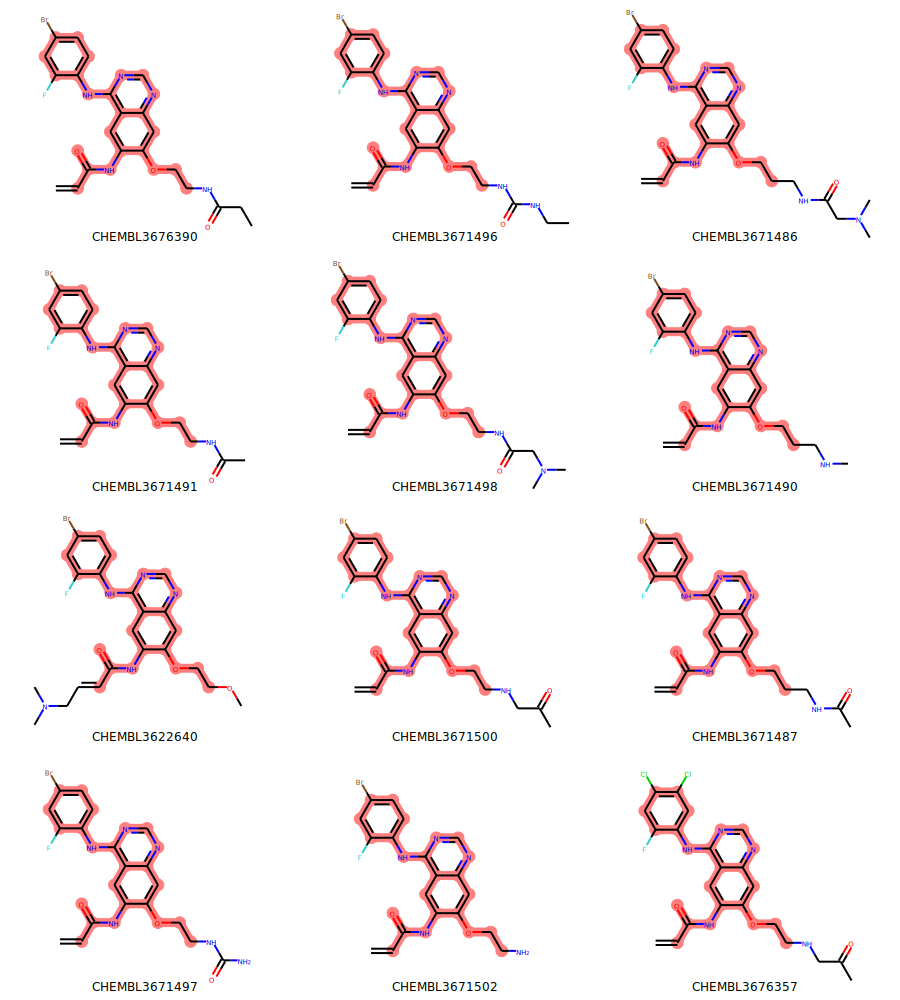

In [6]:
highlightMolecules(mols, mcs1, 12)

In [7]:
img = highlightMolecules(mols, mcs1, 3)

# Get SVG data
molsvg = img.data

# Set background to transparent
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
# Enlarge size of label
molsvg = molsvg.replace("12px", "20px")

# Save altered SVG data to file
f = open("../data/T6/mcs_largestcluster.svg", "w")
f.write(molsvg)
f.close()

#### Set a threshold

It is possible to lower the threshold for the substructure, for example so that the MCS only has to occur in 80% of the input structures.

In [8]:
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)

MCS2 contains 28 atoms and 30 bonds.
SMARTS string: [#6]-[#7]-[#6]-[#6]-[#8]-[#6]1:[#6]:[#6]2:[#7]:[#6]:[#7]:[#6](:[#6]:2:[#6]:[#6]:1-[#7]-[#6](=[#8])-[#6]=[#6])-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#9]


SMARTS string: [#6]-[#7]-[#6]-[#6]-[#8]-[#6]1:[#6]:[#6]2:[#7]:[#6]:[#7]:[#6](:[#6]:2:[#6]:[#6]:1-[#7]-[#6](=[#8])-[#6]=[#6])-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#9]


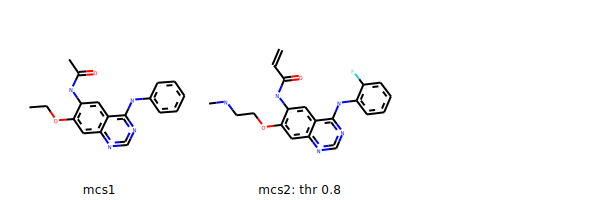

In [9]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1,m2], legends=['mcs1', 'mcs2: thr 0.8'])

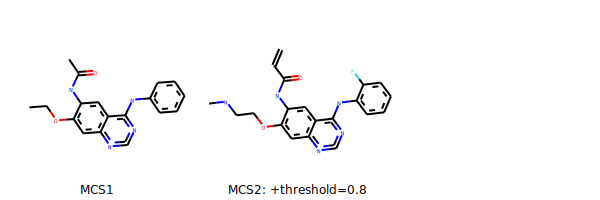

In [10]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

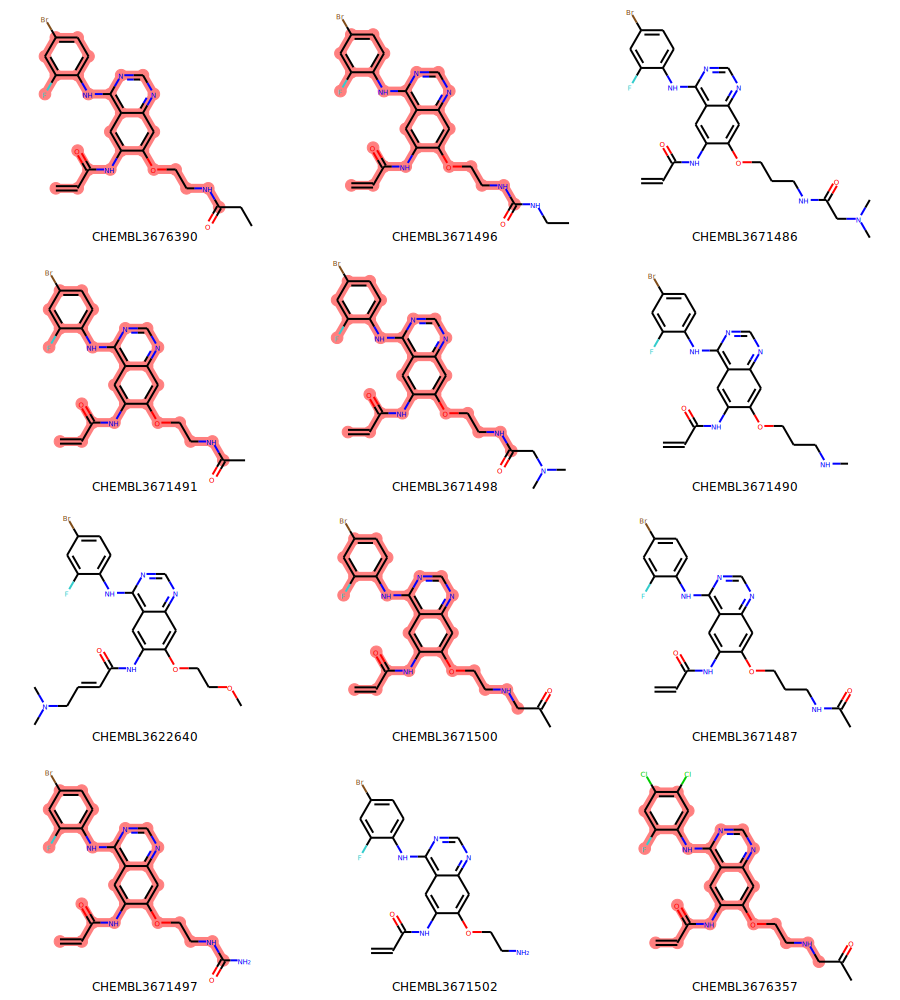

In [11]:
highlightMolecules(mols, mcs2, 12)

As we can see in this example, some molecules were now left out due to the set threshold (`0.8`). This threshold allows to find a larger common substructure that contains, e.g., a benzene with a meta-substitution fluor pattern and a longer alkane chain.

#### Match ring bonds

In the above example it may not be obvious, but by default ring bonds can match non-ring bonds. 
Often from an application point of view, we want to retain rings. Thus, one can set the `ringMatchesRingOnly` parameter to ```True```, then only ring bonds match with other ring bonds.

In [12]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)

MCS3 contains 28 atoms and 30 bonds.
SMARTS string: [#6]-[#7]-[#6]-[#6]-[#8]-[#6]1:[#6]:[#6]2:[#7]:[#6]:[#7]:[#6](:[#6]:2:[#6]:[#6]:1-[#7]-[#6](=[#8])-[#6]=[#6])-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1-[#9]


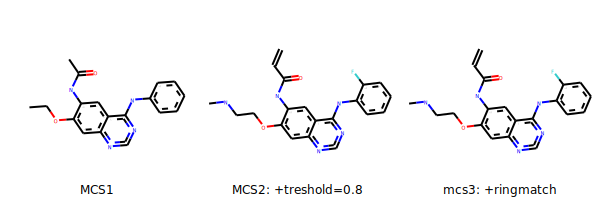

In [13]:
# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

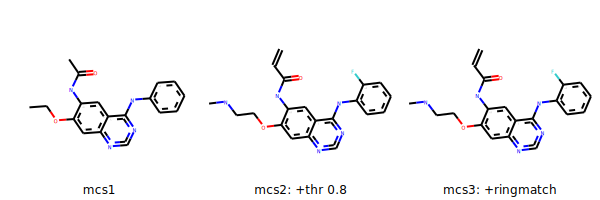

In [14]:
mcs3 = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True, threshold=0.8)
# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1,m2,m3], legends=['mcs1', 'mcs2: +thr 0.8','mcs3: +ringmatch'])

We can see here that depending on the chosen thresholds and parameters, we get slightly different MCS. Note that there are more parameter options available in the [rdkit FMCS module](http://www.rdkit.org/docs/source/rdkit.Chem.fmcs-fmcs.html), e.g. considering atom, bond or valence matching. 

### A more diverse set: the EGFR compounds downloaded from ChEMBL

We restrict the data to only highly active molecules (pIC50>9) and detect the maximum common scaffold in this subset.

In [15]:
# Read full EGFR data
mol_df=pd.read_csv('../data/T1/EGFR_compounds.csv', index_col=0)
print("Total number of compounds:", mol_df.shape[0])

# Only keep molecules with pIC50 > 9 (IC50 > 1nM)
mol_df = mol_df[mol_df.pIC50 > 9]
print("Number of compounds with pIC50 > 9:", mol_df.shape[0])

Total number of compounds: 5428
Number of compounds with pIC50 > 9: 191


,molecule_chembl_id,units,IC50,smiles,pIC50,ROMol
0,CHEMBL63786,nM,0.003,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,
1,CHEMBL53711,nM,0.006,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,
2,CHEMBL35820,nM,0.006,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,

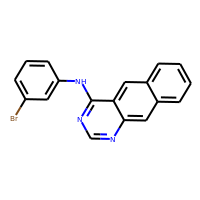
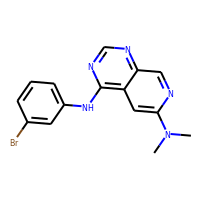
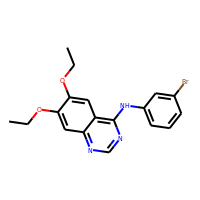

In [16]:
# Add molecule column to data frame
PandasTools.AddMoleculeColumnToFrame(mol_df, 'smiles')
mol_df.head(3)

We do our calculations on the selected highly active molecules only.

In [17]:
mols_diverse = []
# Note: discarded variables we do not care about are usually referred to with a single underscore
for _, row in mol_df.iterrows():
    m = Chem.MolFromSmiles(row.smiles)
    m.SetProp("_Name", row.molecule_chembl_id)
    mols_diverse.append(m)

In the interest of time, we randomly pick 50 molecules from this set.

In [28]:
# We have fixed the random seed above (imports) for deterministic results
mols_diverse_sample = random.sample(mols_diverse, 50)

We now calculate the same three variants of MCSs as described above and draw the respective substructures. We use a slightly lower threshold to account for the larger diversity in the set.

In [29]:
threshold_diverse = 0.7
mcs1 = rdFMCS.FindMCS(mols_diverse_sample)
print("SMARTS string1:", mcs1.smartsString)
mcs2 = rdFMCS.FindMCS(mols_diverse_sample, threshold=threshold_diverse)
print("SMARTS string2:", mcs2.smartsString)
mcs3 = rdFMCS.FindMCS(mols_diverse_sample, ringMatchesRingOnly=True, threshold=threshold_diverse)
print("SMARTS string3:", mcs3.smartsString)

SMARTS string1: [#6](:,-[#6]-,:[#7]-,:[#6](:,-[#6]:[#6]:[#6]:[#6]):,-[#6]):,-[#6]:,-[#7]:,-[#6]
SMARTS string2: [#6]1:[#6]:[#6](:,-[#7]:,-[#6]:[#7]:[#6]-,:[#7]-,:[#6](:[#6]:[#6]:[#6]:[#6]):[#6]):[#6]:[#6]:[#6]:1
SMARTS string3: [#6]:[#6]:[#6]1:[#6](-[#7]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]:[#6]:[#7]:[#6]:1:[#6]


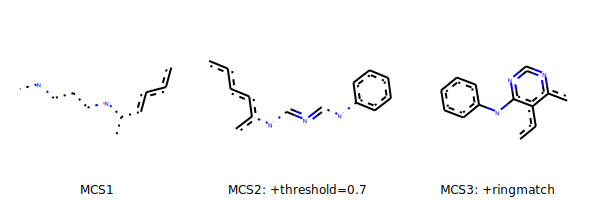

In [30]:
# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage(
    [m1, m2, m3],
    legends=[
        "MCS1",
        f"MCS2: +threshold={threshold_diverse}",
        "MCS3: +ringmatch",
    ],
)

This time it become more clear that setting `ringMatchesRingOnly=True` provides a more intuitive representation of the scaffold they share.

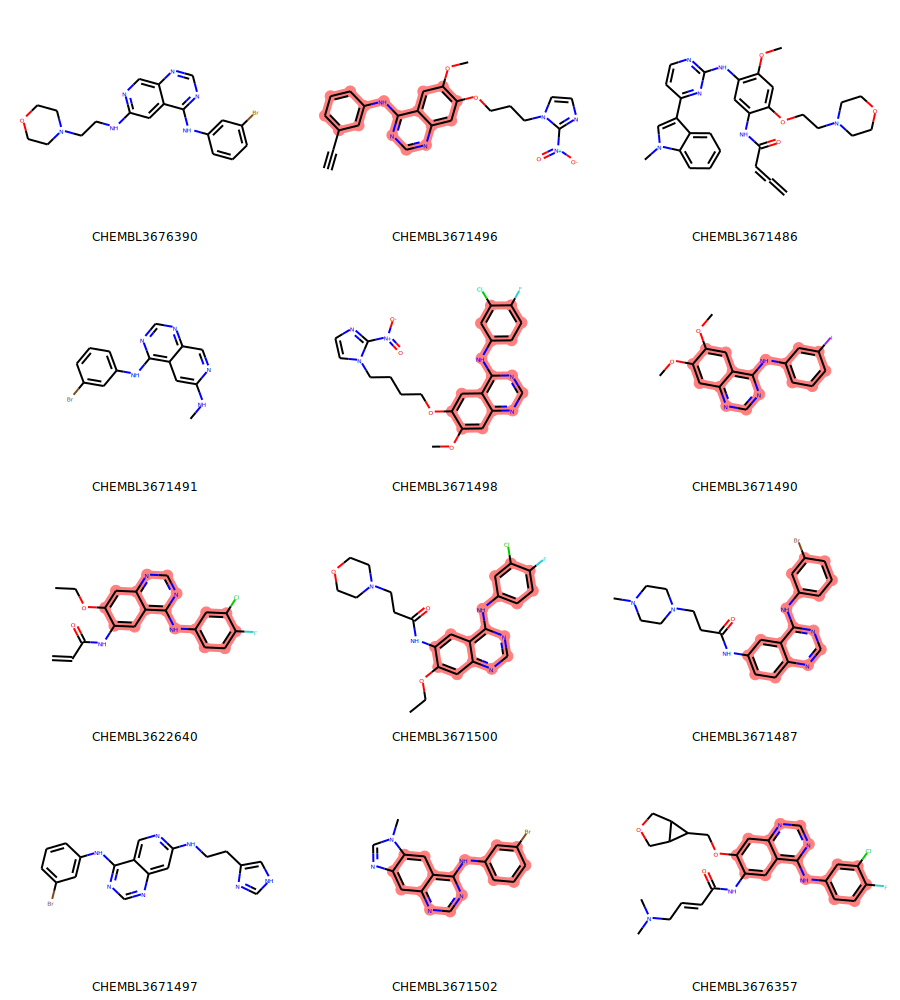

In [31]:
highlightMolecules(mols_diverse_sample, mcs2, 12)

### Identification of MCS using interactive cut-off adaption

We can also change the threshold interactively. For that, we need a helper function, hereby defined. It takes two arguments: `molecules` (fixed, so it's not configurable with a widget) and `percentage` (the value of which is determined by the interactive widget). Every time you modify the state of the slider, this helper function is called.

In [22]:
def render_mcs(molecules, percentage):
    """Interactive widget helper. `molecules` must be wrapped in `ipywidgets.fixed()`,
    while `percentage` will be determined by an IntSlider widget."""
    tmcs = rdFMCS.FindMCS(molecules, threshold=percentage / 100.0)
    if tmcs is None:
        print("No MCS found")
        return None

    m = Chem.MolFromSmarts(tmcs.smartsString)
    print(tmcs.smartsString)
    return m

In [23]:
# Note that the slider may take a few seconds to react
interact(
    render_mcs,
    molecules=fixed(mols_diverse_sample),
    percentage=widgets.IntSlider(min=0, max=100, step=10, value=70),
);

interactive(children=(IntSlider(value=70, description='percentage', step=10), Output()), _dom_classes=('widget…

## Quiz

* Why is the calculation of the maximum common substructure (MCS) useful?
* Can you briefly describe how an MCS can be calculated? 
* How does the typical fragment of an active EGFR compound look like?  